**Содержание**

**1. Основа проекта**
*   1.1 О наборе данных
*   1.2 Словарь

**2. Data Preparation**
*   2.1 Загрузка данных
*   2.2 Отчистка данных
*   2.3 Исследование данных

**3. Бутстреп** 

**4. Наивный подход**
**5. Дельта метод**







**1.Основа проекта**

Этот проект основан на данных, предоставленных на https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing?datasetId=1660669. Это простая маркетинговая кампания с экспериментальной и контрольной группами для A/B-тестирования.

****1.1 О dataset-е****

**Создание A/B тестирования для dataset-а**
Маркетинговые компании стремятся проводить успешные кампании, но рынок сложен, и существует несколько вариантов, которые могут сработать. Поэтому обычно они проводят A/B-тестирование, которое представляет собой процесс случайного эксперимента, при котором две или более версии переменной (веб-страница, элемент страницы, баннер и т. д.) одновременно показываются разным сегментам людей для определения, какая версия оказывает максимальное воздействие и способствует достижению бизнес-метрик.

Компании интересуются ответом на два вопроса:

1. Сколько должно быть рекламы просмотренно человеком, чтобы с 90% вероятностью он обратился в магазин?
2. с 99% вероятностью?

С учетом второго вопроса мы обычно проводим A/B-тестирование. Большинство людей будут видеть рекламу (экспериментальная группа), а небольшая часть людей (контрольная группа) увидит общественное информирование или ничего в точно таком же размере и месте, где обычно размещается реклама.


**1.2 Словарь:**

* **Index**: Индекс строки
* **user id**: Идентификатор пользователя (уникальный)
* **test group**: Если "ad", то человек видел рекламу, если "psa", то он видел общественное информационное объявление
* **converted**: Если человек купил продукт, то значение True, иначе False
* **total ads**: Количество просмотренных рекламных объявлений человеком
* **most ads day**: День, в который человек увидел наибольшее количество рекламы
* **most ads hour**: Час дня, когда человек увидел наибольшее количество рекламы

In [3]:
import numpy as np  # линейная алгебра
import pandas as pd  # обработка данных, чтение и запись файлов CSV

# Входные данные находятся в только для чтения директории "../input/"
# Например, запуск этого кода (нажатие кнопки "Run" или нажатие Shift+Enter) покажет все файлы в директории input

import os
for dirname, _, filenames in os.walk('/TEST'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Можно записывать до 20 ГБ в текущую директорию (/kaggle/working/), которая сохраняется в виде выходных данных при создании версии через "Save & Run All"
# Также можно создавать временные файлы в /kaggle/temp/, но они не будут сохранены после завершения текущей сессии

**2. Подготовка данных** 

**2.1 Загрузка данных**

In [4]:
# импортировать библиотеки и данные
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('marketing_AB.csv')  # загрузить данные из CSV файла
df.head()  # вывод первых нескольких строк данных для ознакомления

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


**2.2 Чистка данных**

После просмотра первых пяти строк таблицы данных мы обнаружили   **один лишний столбец** с названием: Unnamed:0. Этот столбец нужно удалить.

**1.Основа проекта**



In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


После удаления столбца "Unnamed:0", текущие названия столбцов **содержат пробелы между словами**, что может вызвать проблемы в дальнейшем. Чтобы избежать этих проблем, лучше переименовать столбец 'user id' в формат 'user_id'. Поскольку требуется изменить большинство названий столбцов, я буду использовать лямбда-функцию.

In [6]:
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


**2.3 Data Exploration**

Теперь датафрейм выглядит хорошо, поэтому можно проверить, есть ли пропущенные значения.
 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


К счастью, ни в одном из наших столбцов нет пропущенных значений. Вернемся к цели анализа этого проекта: мы хотим узнать, значительно ли запуск рекламы улучшает конверсию. Первое, с чего следует начать, это взглянуть на **размер выборки экспериментальной группы (ad) и контрольной группы (psa).** 

In [8]:
# count the numbers of different groups of the categorical column
df['test_group'].value_counts()

test_group
ad     564577
psa     23524
Name: count, dtype: int64

In [9]:
# count the True or False of buying products by grouping test_group.
df.groupby('test_group')['total_ads'].value_counts()

test_group  total_ads
ad          1            54298
            2            37911
            5            28024
            3            27328
            4            22401
                         ...  
psa         312              1
            310              1
            184              1
            179              1
            907              1
Name: count, Length: 1153, dtype: int64

Очевидно, что размер выборки рекламы **намного больше, чем** размер выборки PSA. Когда размеры выборок экспериментальной и контрольной групп **несбалансированы**, это потенциально может привести к появлению **определенных проблем** или соображений в статистическом анализе, например, повлиять на статистическую мощность анализа и точность оценок. Например, на точность оценок, таких как средние значения или пропорции, может влиять несбалансированный размер выборки. Группа с большим размером выборки обычно будет иметь более точные оценки по сравнению с группой с меньшим размером выборки. Поэтому в этом случае мы рассматриваем такие стратегии, как сопоставление, стратификация или использование соответствующих статистических методов, которые могут учитывать несбалансированные размеры выборки, таких как взвешенный анализ или **методы повторной выборки, такие как бутстрэппинг.**

Прежде чем выполнять начальную загрузку, мы можем сначала **подставить исходный фрейм данных** в фрейм данных экспериментальной группы и фрейм данных контрольной группы.

In [10]:
#subset the original dataframe
ad_experimental=df[df['test_group']=='ad']

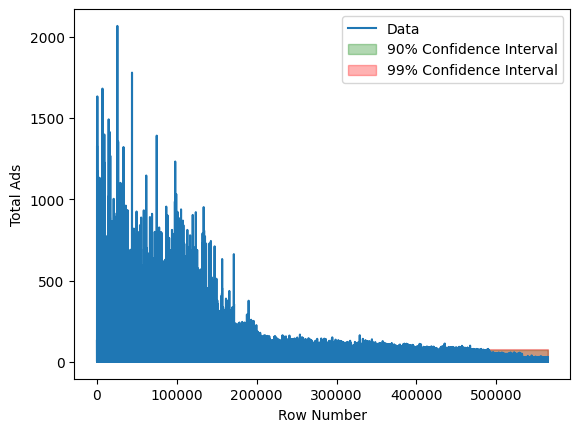

90 8.258764264806263 74.61158053440475
99 7.7676882891547905 79.32855080173483


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm

# Define your confidence interval function
def confidence_interval(data, alpha):
    n = len(data)
    mean = np.mean(data)
    std_error = np.std(data) / np.sqrt(n)

    z_value = lognorm.ppf(1 - alpha/2, s=std_error)
    lower_bound = mean * np.exp(-z_value)
    upper_bound = mean * np.exp(z_value)

    return lower_bound, upper_bound

alpha_90 = 0.1
alpha_99 = 0.01



# Compute the confidence intervals
ad_converted_90 = confidence_interval(ad_experimental['total_ads'], alpha_90)
ad_converted_99 = confidence_interval(ad_experimental['total_ads'], alpha_99)

# Generate the x-axis values (row numbers)
x = np.arange(len(ad_experimental))

# Plot the data points
plt.plot(x, ad_experimental['total_ads'], label='Data')

# Plot the 90% confidence interval
plt.fill_between(x, ad_converted_90[0], ad_converted_90[1], color='green', alpha=0.3, label='90% Confidence Interval')

# Plot the 99% confidence interval
plt.fill_between(x, ad_converted_99[0], ad_converted_99[1], color='red', alpha=0.3, label='99% Confidence Interval')

# Add labels and legend
plt.xlabel('Row Number')
plt.ylabel('Total Ads')
plt.legend()

# Show the plot
plt.show()


print("90",ad_converted_90[0],ad_converted_90[1])
print("99",ad_converted_99[0],ad_converted_99[1])

Данный интервал является результатом наивного подхода. Однако, далее, при помощи метода бутстрэп, я буду стремиться улучшить его точность. 

**3. Бутстреп**

Метод бутстреп — это **метод повторной выборки**, используемый в статистическом анализе. По сути, он включает в себя повторную выборку наблюдений из набора данных с заменой для создания нескольких повторных выборок. Этот процесс повторной выборки позволяет **оценить выборочное распределение статистики или сделать выводы о параметрах совокупности**. В этом проекте я собираюсь выполнить повторную выборку исходного файла данных, чтобы создать **кадры данных с повторной выборкой из 1000 выборочных средних** как для экспериментальной группы, так и для контрольной группы.

In [12]:

# создаем пустой список для хранения загрузочных средств
boot_ad_1 = []
boot_ad_2 = []
boot_ad_3 = []
boot_ad_4 = []
# настройте цикл, который будет повторяться 1000 раз. На каждой итерации будет генерироваться новый загрузочный образец.
for i in range(1000):
    boot_sample = ad_experimental.sample(frac=1, replace=True)['total_ads']

    boot_interval_90  =  confidence_interval(boot_sample, alpha_90)
    boot_ad_1.append(boot_interval_90[0])
    boot_ad_2.append( boot_interval_90[1])

    boot_interval_99  =  confidence_interval(boot_sample, alpha_99)
    boot_ad_3.append(boot_interval_99[0])
    boot_ad_4.append( boot_interval_99[1])
    

boot_ad_90=pd.DataFrame(boot_ad_2, boot_ad_1)
boot_ad_99=pd.DataFrame(boot_ad_3, boot_ad_4)



    

In [13]:

print ("AD_bootstrap_90", sum(boot_ad_1) / len(boot_ad_1),sum(boot_ad_2) / len(boot_ad_2)) 
print("AD_simple_90",ad_converted_90[0],ad_converted_90[1])

print ("AD_bootstrap_99", sum(boot_ad_3) / len(boot_ad_3),sum(boot_ad_4) / len(boot_ad_4)) 
print("AD_simple_99",ad_converted_99[0],ad_converted_99[1])



AD_bootstrap_90 8.258954401849559 74.61786863342819
AD_simple_90 8.258764264806263 74.61158053440475
AD_bootstrap_99 7.767713768539264 79.33688493122295
AD_simple_99 7.7676882891547905 79.32855080173483
